In [3]:
# import os
# print("Current working directory:", os.getcwd())

## Import Packages

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta


## Import Dataset

In [48]:
# Load the .dta file into a DataFrame
df = pd.read_csv("/home/jovyan/work/deposit-prediction/cleaned_data/data_clean.csv")
df.head(5)

# Load the .dta file into a DataFrame
# df = pd.read_stata("/home/jovyan/work/deposit-prediction/cleaned_data/data2.dta")
# df.head(5)


,Date,Real GDP growth,Nominal GDP growth,Real disposable income growth,Nominal disposable income growth,Unemployment rate,CPI inflation rate,3-month Treasury rate,5-year Treasury yield,10-year Treasury yield,...,Prime rate,House Price Index (Level),Commercial Real Estate Price Index (Level),Loans to individuals,Credit cards,Other loans to individuals,Deposits,Interest-bearing deposits,Noninterest-bearing deposits,Time deposits
0,1984Q1,8.1,12.5,7.9,12.7,7.9,5.8,9.2,11.7,11.9,...,11.1,49.0,90.5,261504,46521,214984,2697459,1860467,363956,1242574
1,1984Q2,7.1,10.8,6.6,10.8,7.4,3.8,9.8,13.0,13.2,...,12.3,49.6,91.4,277997,51159,226839,2773230,1921613,379300,1306506
2,1984Q3,3.9,7.7,5.3,8.6,7.4,3.5,10.3,12.8,12.9,...,13.0,50.3,92.0,293062,56645,236417,2781986,1964713,364125,1370983
3,1984Q4,3.3,6.4,3.4,5.9,7.3,3.5,8.8,11.5,11.8,...,11.8,50.7,92.5,311074,64110,246963,2907668,2043037,421536,1407295
4,1985Q1,3.9,8.1,-1.0,3.8,7.2,3.7,8.2,11.3,11.6,...,10.5,51.3,93.2,319656,67028,252628,2916647,2086014,371462,1413727


In [49]:
df["Deposits"]

0       2697459
1       2773230
2       2781986
3       2907668
4       2916647
         ...   
155    19214756
156    18742758
157    18644207
158    18553633
159    18813707
Name: Deposits, Length: 160, dtype: int64

## Exploratory Data Analysis

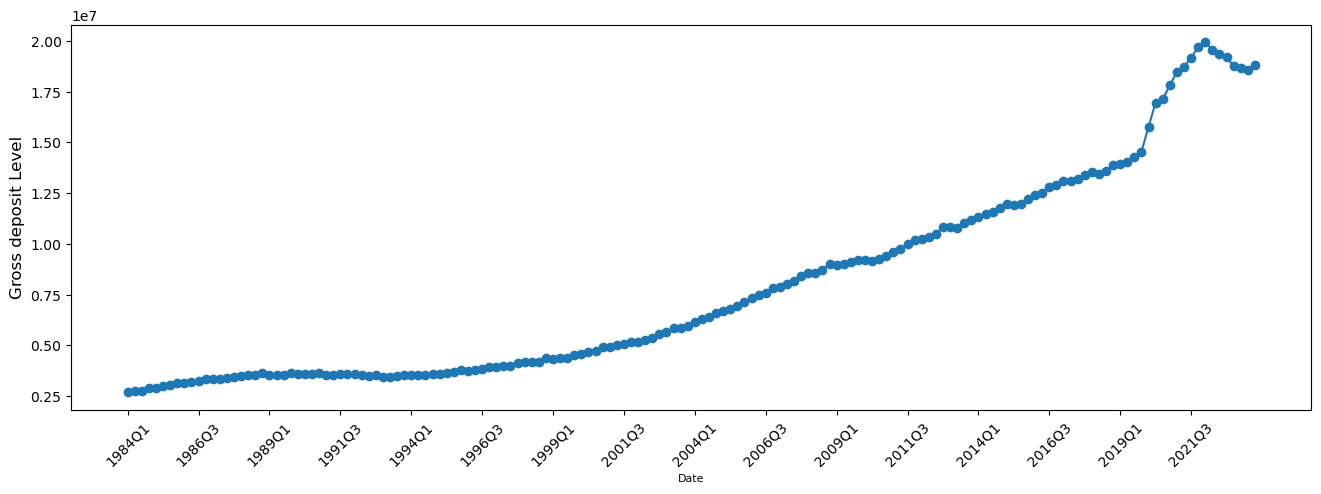

In [50]:
plt.figure(figsize=(16,5))
plt.plot(df.Date, df["Deposits"], '-o')
plt.xticks(df.Date[::10], rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Date", fontsize=8)
plt.ylabel("Gross deposit Level", fontsize=12)
plt.show()

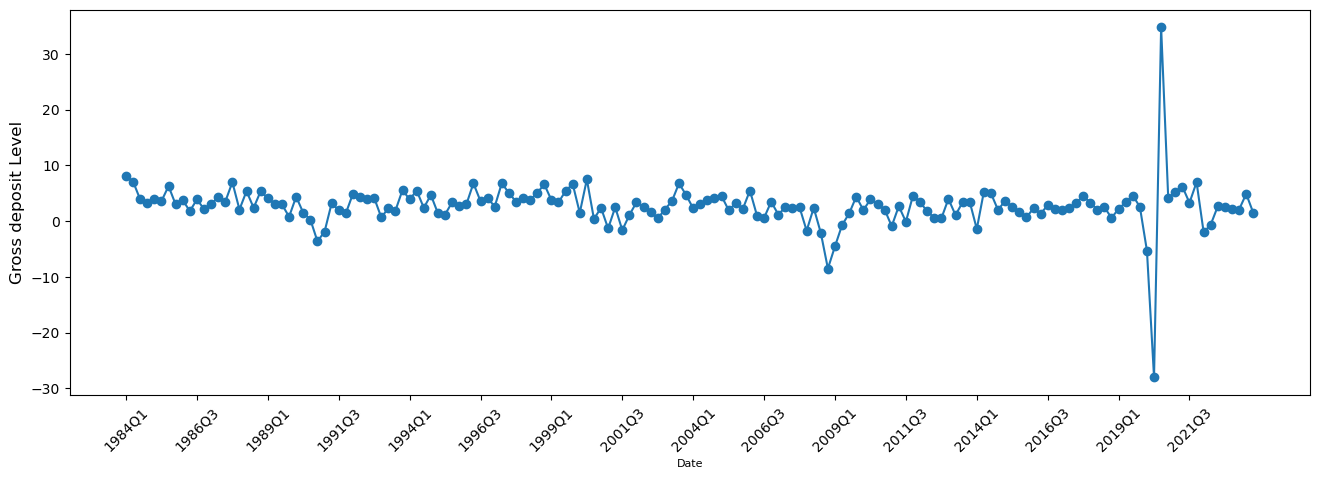

In [53]:
plt.figure(figsize=(16,5))
plt.plot(df.Date, df["Real GDP growth"], '-o')
plt.xticks(df.Date[::10], rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Date", fontsize=8)
plt.ylabel("Gross deposit Level", fontsize=12)
plt.show()

## Stationary Analysis

### ADF Test

In [54]:
from statsmodels.tsa.stattools import adfuller, acf, pacf

# Function to apply ADF test and return results
def adf_test(series, column_name):
    result = adfuller(series.dropna())  # Dropping NA values to avoid errors
    output = {
        'Test Statistic': result[0],
        'p-value': result[1],
        'Lags Used': result[2],
        'Number of Observations': result[3],
        'Critical Values': result[4],
    }
    return pd.DataFrame(output, index=[column_name])

# Running ADF test on the deposits
adf_deposits = adf_test(df.Deposits, "Deposit")
adf_deposits

,Test Statistic,p-value,Lags Used,Number of Observations,Critical Values
Deposit,3.176465,1.0,14,145,NaN


### ACF and PACF

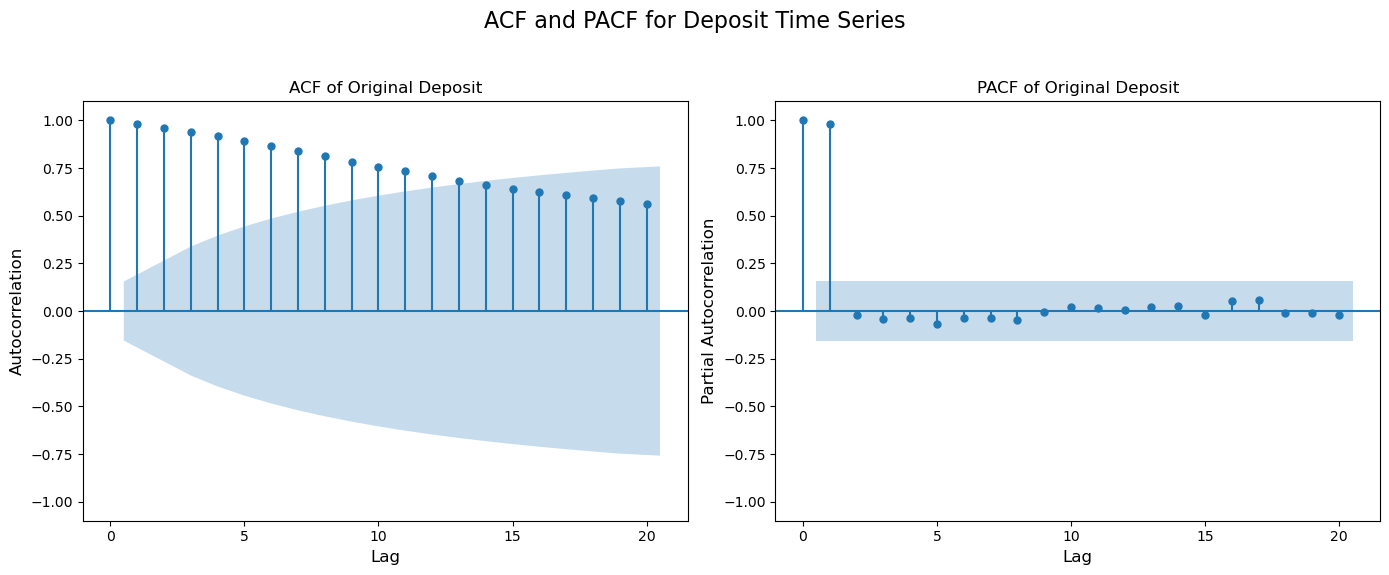

In [56]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
import matplotlib.pyplot as plt

# Compute ACF and PACF for the differenced series
lags = 20  # Number of lags to plot
acf_differenced = acf(df.Deposits, nlags=lags, fft=True)  # Use the differenced series
pacf_differenced = pacf(df.Deposits, nlags=lags)

# Plot the ACF and PACF for the differenced series
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("ACF and PACF for Deposit Time Series", fontsize=16)

# ACF plot using statsmodels
sm.graphics.tsa.plot_acf(df.Deposits, lags=lags, ax=axes[0], title="ACF of Original Deposit")
axes[0].set_ylabel("Autocorrelation", fontsize=12)
axes[0].set_xlabel("Lag", fontsize=12)
axes[0].set_ylim(-1.1, 1.1)

# PACF plot using statsmodels
sm.graphics.tsa.plot_pacf(df.Deposits, lags=lags, ax=axes[1], title="PACF of Original Deposit")
axes[1].set_ylabel("Partial Autocorrelation", fontsize=12)
axes[1].set_xlabel("Lag", fontsize=12)
axes[1].set_ylim(-1.1, 1.1)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Differencing

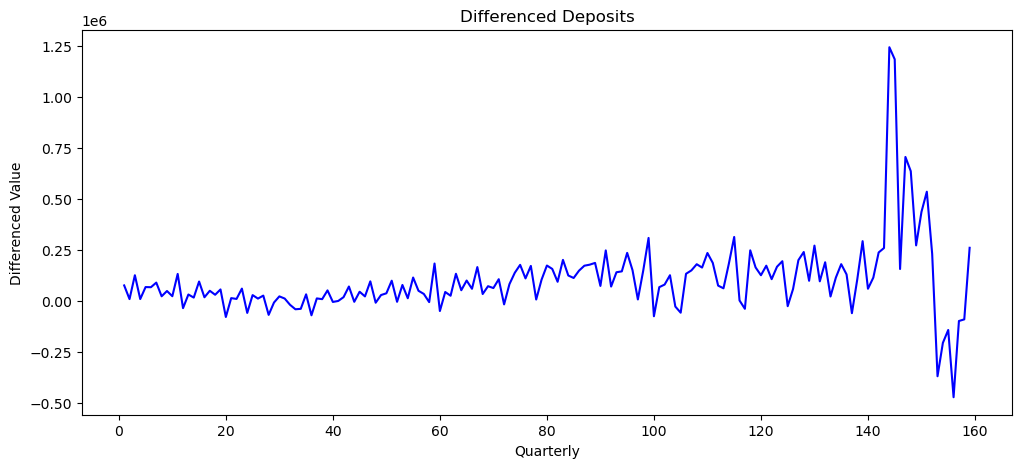

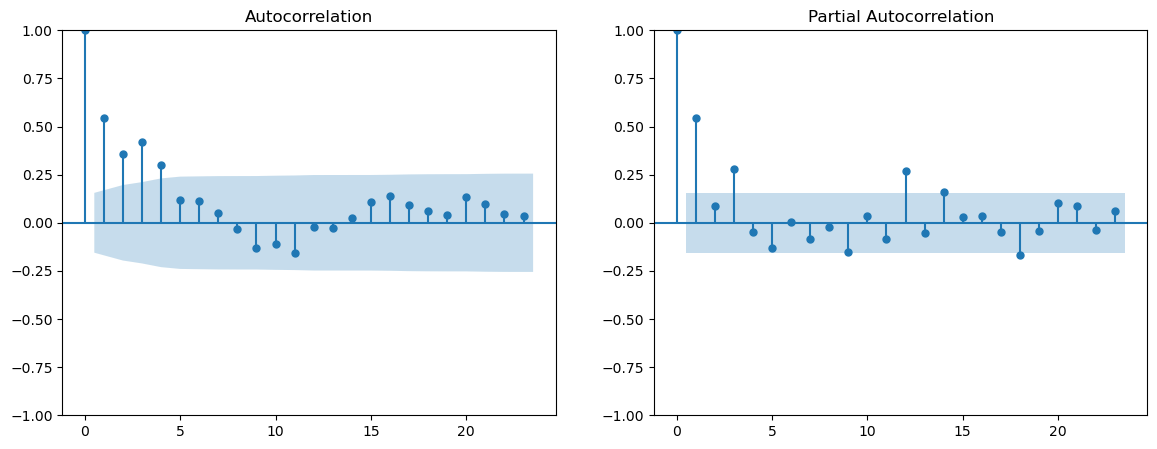

In [57]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Differencing the 'Non-maturity Interest-bearing deposits' series to make it stationary
dg = df.Deposits.copy().diff(1).dropna()

# Plot the differenced series to check for stationarity visually
plt.figure(figsize=(12, 5))
plt.plot(dg, color='blue')
plt.title('Differenced Deposits')
plt.xlabel('Quarterly')
plt.ylabel('Differenced Value')
plt.show()

# Step 2: Plot ACF and PACF to determine the order of ARIMA
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(dg, ax=ax[0])
plot_pacf(dg, ax=ax[1])

plt.show()

In [58]:
# Running ADF test on the deposits
adf_deposits_diff = adf_test(dg, "Deposit Difference")
adf_deposits_diff

,Test Statistic,p-value,Lags Used,Number of Observations,Critical Values
Deposit Difference,-0.654949,0.858076,14,144,NaN


Some comments about ARIMA, SARIMA, and SARIMAX...

In [59]:
int(0.2*df.shape[1])

4

## Train-Test Split

In [18]:
# Model Evaluation & Hyperparameter Tuning
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Feature Engineering and Data Handling
from sklearn.preprocessing import StandardScaler

size = int(0.2*df.shape[1])
df_train = df.iloc[:-size].copy()
df_test = df.drop(df_train.index).copy()

dep_train = df['deposits'].iloc[:-size].copy()
date_train = df['time'].iloc[:-size].copy()
# tv_test = df.drop(tv_train.index).copy()
dep_test = df.drop(dep_train.index).copy()
date_test = df.drop(date_train.index).copy()


## ARIMA 

In [2]:
from statsmodels.tsa.api import ARIMA
# !pip install pmdarima
from pmdarima import auto_arima

In [ ]:
# arima = ARIMA(dep_train.values,order=(1, 1, 0), D = 1, m=5).fit()
sarima = auto_arima(dep_train.values, trace=True, seasonal=True, D = 1, m=36)
sarima.summary()
# sarima = ARIMA(dep_train.values,
#                     order = (1,1,1),
#                     seasonal_order = (2,1,0,36)).fit()
# sarima.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[36]             : AIC=2225.341, Time=5.10 sec
 ARIMA(0,1,0)(0,1,0)[36]             : AIC=2299.874, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[36]             : AIC=inf, Time=3.67 sec
 ARIMA(0,1,1)(0,1,1)[36]             : AIC=2233.451, Time=0.75 sec
 ARIMA(2,1,2)(0,1,1)[36]             : AIC=2232.282, Time=4.39 sec
 ARIMA(2,1,2)(1,1,0)[36]             : AIC=2223.868, Time=6.33 sec
 ARIMA(2,1,2)(0,1,0)[36]             : AIC=2268.098, Time=0.48 sec
 ARIMA(2,1,2)(2,1,0)[36]             : AIC=2225.363, Time=9.70 sec
 ARIMA(2,1,2)(2,1,1)[36]             : AIC=2227.330, Time=15.19 sec
 ARIMA(1,1,2)(1,1,0)[36]             : AIC=2205.215, Time=7.26 sec
 ARIMA(1,1,2)(0,1,0)[36]             : AIC=2266.446, Time=0.26 sec
 ARIMA(1,1,2)(2,1,0)[36]             : AIC=2223.438, Time=7.28 sec
 ARIMA(1,1,2)(1,1,1)[36]             : AIC=2223.416, Time=4.06 sec
 ARIMA(1,1,2)(0,1,1)[36]             : AIC=2230.422, Time=2.42 sec


In [13]:
sarima = ARIMA(dep_train.values,
                    order = (2,0,1),
                    seasonal_order = (0,1,1,12)).fit()
sarima.summary()


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                                y   No. Observations:                  142
Model:             ARIMA(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood               -1348.937
Date:                          Thu, 21 Nov 2024   AIC                           2707.873
Time:                                  01:15:55   BIC                           2722.211
Sample:                                       0   HQIC                          2713.699
                                          - 142                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4435      0.264      5.472      0.000       0.926       1.961
ar.L2         -0.4436      0.264     -1.681      0.093      -0.961       0.074
ma.L1          0.1226      0.270      0.454      0.650      -0.406       0.651
ma.S.L12      -0.9629      0.060    -16.151      0.000      -1.080      -0.846
sigma2      5.234e+07   3.96e-09   1.32e+16      0.000    5.23e+07    5.23e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              1168.73
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               3.30   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.24e+32. Standard errors may be unstable.
"""

## Model Evaluation

In [14]:
def mase(y_train, y_test, y_preds):
    n = len(y_train)
    m = len(y_test)
    denom = 0
    for i in range(n-m):
        denom += np.abs(y_train[i+1:i+m+1] - y_train[i]*np.ones(m)).mean()
    denom = denom / (n-m)
    num = np.abs(y_test - y_preds).mean()
    return num/denom

In [16]:
# MASE analysis:

test_mase = mase(y_train = dep_train.values, y_test = dep_test.deposits.values, y_preds = sarima.forecast(len(dep_test)))


## Results

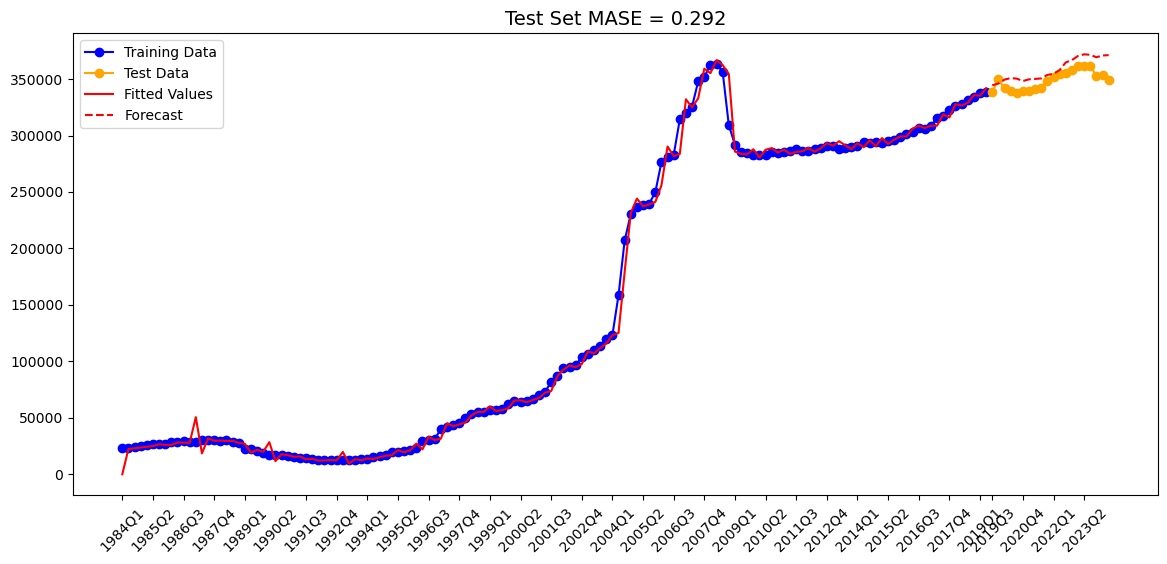

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(14,6))

# Plot training data
plt.plot(date_train,
         dep_train,
         'b-o',
         label='Training Data')

# Plot test data
plt.plot(date_test.time,
         dep_test.deposits,
         color='orange',
         marker='o',
         label='Test Data')

# Plot fitted values for training data
plt.plot(date_train,
         sarima.fittedvalues,
         'r',
         label='Fitted Values')

# Forecasting and plotting for test data
plt.plot(date_test.time,
         sarima.forecast(len(date_test)),
         '--r',
         label="Forecast")
plt.title("Test Set MASE = " + str(np.round(test_mase,3)),
             fontsize=14)
# Customize x-axis ticks to display every 10th label with rotation
xticks = np.concatenate([date_train[::5], date_test.time[::5]])

# Set combined x-ticks with rotation and font size
plt.xticks(xticks, rotation=45, fontsize=10)
plt.legend()
plt.show()







In [20]:
rolling_avg_train_preds = dep_train.rolling(12).mean()
rolling_avg_test_preds = rolling_avg_train_preds.iloc[-1] * np.ones(len(dep_test))


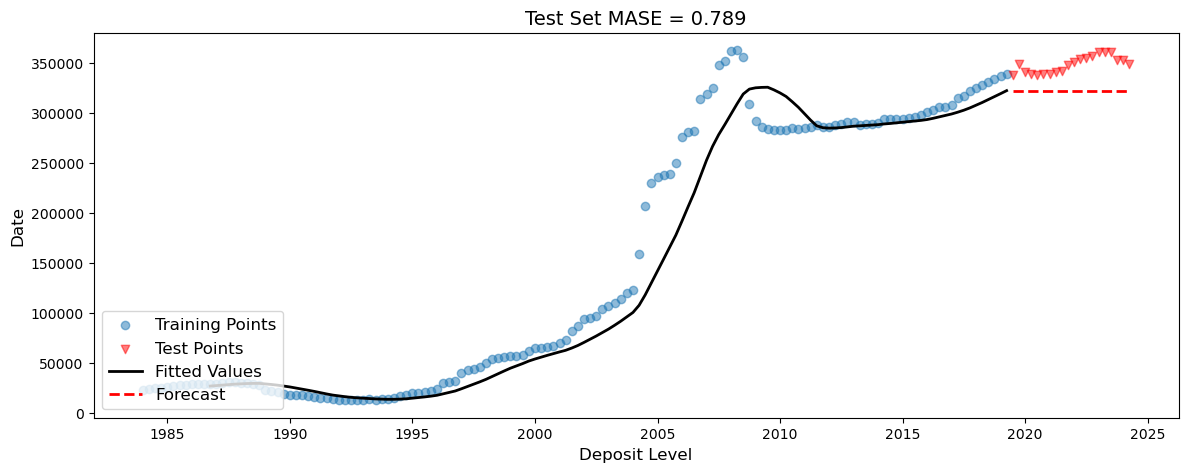

In [21]:
#baseline:
plt.figure(figsize=(14,5))
plt.scatter(df_train['date'],
              dep_train,
               alpha=.5,
               label="Training Points")

plt.scatter(date_test.date,
               dep_test.deposits,
               alpha=.5,
               c = 'red',
               marker = 'v',
               label="Test Points")

plt.plot(df_train['date'],
            rolling_avg_train_preds,
            'k-',
            linewidth = 2,
            label="Fitted Values")

plt.plot(date_test.date,
            rolling_avg_test_preds,
            'r--',
            linewidth=2,
            label="Forecast")

plt.legend(fontsize=12, loc=3)

test_mase_base = mase(y_train = dep_train, y_test = dep_test.deposits, y_preds = rolling_avg_test_preds)

plt.title("Test Set MASE = " + str(np.round(test_mase_base,3)),
             fontsize=14)

plt.xlabel("Deposit Level", fontsize=12)
plt.ylabel("Date", fontsize=12)






plt.show()

In [ ]:
#k fold cross validation
#grid search for best seasonality
